In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import sys
sys.path.append('../spock/')
from modelfitting import ROC_curve
try:
    plt.style.use('paper')
except:
    pass
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc 
from sklearn import metrics

%matplotlib inline

In [2]:
df = pd.read_csv('../training_data/random/additional_featuresNorbits10000.0Nout80trio/trainingdata.csv', index_col=0)
df.head()

,EMfracstdnear,EPstdnear,AMDfracnear,MMRstrengthnear,betanear,AMDcritnear,EMcrossnear,jnear,knear,EMfracstdfar,...,Z07Stable_avg,Z07Stable_worstpair,deltaQ11inner,deltaQ11outer,deltaQ11avg,Q11log_instability_time_inner,Q11log_instability_time_outer,Q11log_instability_time_avg,Q11Stable_avg,Q11Stable_worstpair
0,0.017511,0.002935,0.178882,0.104761,5.899524,1.528816e-06,0.221502,4.0,1.0,0.085965,...,False,False,0.181336,0.231297,0.206317,6.199812,8.474201,7.234686,False,False
1,0.072425,0.011408,18.030819,0.031489,5.822156,2.887466e-08,0.190647,4.0,1.0,0.005881,...,False,False,0.160121,0.287636,0.223878,6.210605,8.176953,7.589789,False,False
2,0.034442,0.001506,0.762864,0.326185,2.399923,1.618682e-06,0.125660,6.0,1.0,0.016461,...,False,False,0.111632,0.418793,0.265212,2.888476,9.623663,7.075861,False,False
3,0.008561,0.002451,0.822371,0.012940,12.836670,6.619971e-08,0.216684,4.0,1.0,0.003955,...,False,False,0.178094,0.190585,0.184339,9.248119,9.342286,9.613325,True,True
4,0.551761,0.002103,9.891405,NaN,2.030812,3.426953e-10,0.024455,28.0,1.0,0.361442,...,False,False,0.032936,0.023871,0.028404,4.979716,2.579815,3.439946,False,False


In [3]:
dfres = pd.read_csv('resPratios.csv', index_col=0)
dfrand = pd.read_csv('randomPratios.csv', index_col=0)

# Models trained on resonant dataset

Test on full 25,000 random systems

N-body AUC = 0.9910 Thresh = 0.005 TPR = 0.998 FPR = 0.108 Thresh = 0.943 TPR = 0.974 FPR = 0.015
3785
SPOCK AUC = 0.9771 Thresh = 0.210 TPR = 0.942 FPR = 0.100 Thresh = 0.356 TPR = 0.900 FPR = 0.070
MEGNO AUC = 0.9529 Thresh = 0.366 TPR = 0.872 FPR = 0.100 Thresh = 0.331 TPR = 0.904 FPR = 0.118
AMD AUC = 0.8980 Thresh = 0.413 TPR = 0.729 FPR = 0.101 Thresh = 0.293 TPR = 0.901 FPR = 0.323
Hill AUC = 0.8159 Thresh = 0.447 TPR = 0.388 FPR = 0.101 Thresh = 0.268 TPR = 0.904 FPR = 0.398


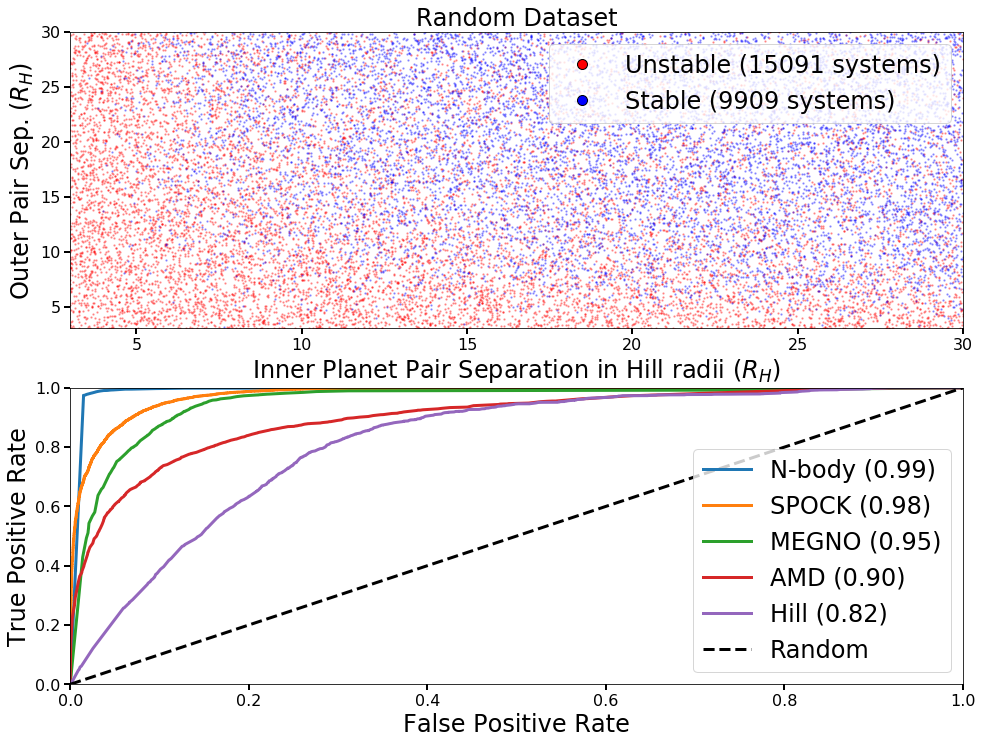

In [4]:
from xgboost.sklearn import XGBClassifier

fs = 24
FPRthresh=0.1
TPRthresh=0.9

models = {'N-body':'nbody', 'SPOCK':'featureclassifier', 'MEGNO':'megno', 'AMD':'AMD', 'Hill':'hill'}
featuresdic = {'N-body':['shadow_instability_time'], 'SPOCK':None, 'MEGNO':['MEGNO'], 'AMD':['AMDfracnear', 'AMDfracfar'], 'Hill':['betanear', 'betafar']}

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(2, 1, figure=fig)
gs.update(hspace=0.2)

stable = dfrand['instability_time'] > 9.99e8
ax1 = plt.subplot(gs[0])
ax1.set_rasterization_zorder(1)
ax1.scatter(dfrand['beta12'][~stable], dfrand['beta23'][~stable], c = 'r', s=2, alpha=0.3, zorder=0)
ax1.scatter(dfrand['beta12'][stable], dfrand['beta23'][stable], c = 'b', s=2, alpha=0.3, zorder=0)

ax1.set_xlim([3,30])
ax1.set_ylim([3,30])
ax1.set_xlabel(r'Inner Planet Pair Separation in Hill radii ($R_H$)', fontsize=fs)
ax1.set_ylabel(r'Outer Pair Sep. ($R_H$)', fontsize=fs)
ax1.locator_params(nbins=6)
ax1.set_title('Random Dataset')


Nstable = stable.sum()
Nunstable = (~stable).sum()
legend_elements = [Line2D([0], [0], marker='o', lw=0, c='k', markerfacecolor='r', label='Unstable ({0} systems)'.format(Nunstable), markersize=10),
                   Line2D([0], [0], marker='o', lw=0, c='k', label='Stable ({0} systems)'.format(Nstable), markerfacecolor='b', markersize=10)]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=fs)

testing_dataset = 'random'

ax = plt.subplot(gs[1])

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_ylabel('True Positive Rate', fontsize=fs)
ax.set_xlabel('False Positive Rate', fontsize=fs)


for name, filename in models.items():
    model = XGBClassifier()
    model.load_model('../spock/models/'+filename+'.json')
    if name == 'SPOCK':
        testingdatafolder = '../training_data/random/featuresNorbits10000.0Nout80trio/'  
    elif name == 'N-body':
        testingdatafolder = '../training_data/random/shadowtimes/'
    else:
        testingdatafolder = '../training_data/random/additional_featuresNorbits10000.0Nout80trio/'
    
    dataset = pd.read_csv(testingdatafolder+"trainingdata.csv", index_col = 0)
    labels = pd.read_csv(testingdatafolder+"labels.csv", index_col=0)
    y = labels['Stable']
    
    features = featuresdic[name]
    if features is None:
        features = dataset.columns.values
    
    X = dataset[features]
    preds = model.predict_proba(X)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    if name == 'SPOCK':
        print(len(fpr))
        stride = 10
        np.savetxt('../spock/models/randROC.txt', (ROCthresholds[::stride], tpr[::stride], fpr[::stride]))
    roc_auc = metrics.roc_auc_score(y, preds)
    threshindex = np.where(fpr > FPRthresh)[0][0]
    tprthreshindex = np.where(tpr > TPRthresh)[0][0]
    print(name, "AUC = {0:.4f} Thresh = {1:.3f}".format(roc_auc, ROCthresholds[threshindex]),  "TPR = {0:.3f}".format(tpr[threshindex]), "FPR = {0:.3f}".format(fpr[threshindex]), 
         "Thresh = {0:.3f}".format(ROCthresholds[tprthreshindex]),  "TPR = {0:.3f}".format(tpr[tprthreshindex]), "FPR = {0:.3f}".format(fpr[tprthreshindex]))
    ax.plot(fpr, tpr, label='{0} ({1:.2f})'.format(name, roc_auc))

ax.plot(np.linspace(0,1), np.linspace(0,1), 'k--', label='Random')

ax.legend(fontsize=fs)
fig.savefig('randomperformance.pdf', bbox_inches='tight')